### POS_CASH_balance, installments_payments, credit_card_balance 데이터 가공, EDA, 모델 생성.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

##### 코랩 버전은 Google Drive에서 데이터 세트를 로딩

In [8]:
import os, sys
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### BALANCE 데이터 세트들을 로딩. 메모리 사이즈를 줄이기 위해 컬럼 타입 변경

In [9]:
default_dir = "/content/gdrive/My Drive"

In [10]:
def get_balance_data():
  """
  메모리를 절약하기위해 데이터 타입을 32비트로 변경
  """
  pos_dtype = {
      'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int32, 'SK_DPD':np.int32,
      'SK_DPD_DEF':np.int32,  'CNT_INSTALMENT':np.float32, 'CNT_INSTALMENT_FUTURE':np.float32
  }

  install_dtype = {
      'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'NUM_INSTALMENT_NUMBER':np.int32, 'NUM_INSTALMENT_VERSION':np.float32,
      'DAYS_INSTALMENT':np.float32, 'DAYS_ENTRY_PAYMENT':np.float32, 'AMT_INSTALMENT':np.float32, 'AMT_PAYMENT':np.float32
  }
  
  card_dtype = {
      'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int16,
      'AMT_CREDIT_LIMIT_ACTUAL':np.int32, 'CNT_DRAWINGS_CURRENT':np.int32, 'SK_DPD':np.int32,'SK_DPD_DEF':np.int32,
      'AMT_BALANCE':np.float32, 'AMT_DRAWINGS_ATM_CURRENT':np.float32, 'AMT_DRAWINGS_CURRENT':np.float32,
      'AMT_DRAWINGS_OTHER_CURRENT':np.float32, 'AMT_DRAWINGS_POS_CURRENT':np.float32, 'AMT_INST_MIN_REGULARITY':np.float32,
      'AMT_PAYMENT_CURRENT':np.float32, 'AMT_PAYMENT_TOTAL_CURRENT':np.float32, 'AMT_RECEIVABLE_PRINCIPAL':np.float32,
      'AMT_RECIVABLE':np.float32, 'AMT_TOTAL_RECEIVABLE':np.float32, 'CNT_DRAWINGS_ATM_CURRENT':np.float32,
      'CNT_DRAWINGS_OTHER_CURRENT':np.float32, 'CNT_DRAWINGS_POS_CURRENT':np.float32, 'CNT_INSTALMENT_MATURE_CUM':np.float32
  }

  # 메모리 사이즈를 줄이기 위해 지정된 dtype의 값으로 전달
  # np.uint32로 지정
  pos_bal = pd.read_csv(os.path.join(default_dir, 'POS_CASH_balance.csv'), dtype=pos_dtype)
  install = pd.read_csv(os.path.join(default_dir, 'installments_payments.csv'), dtype=install_dtype)
  card_bal = pd.read_csv(os.path.join(default_dir, 'credit_card_balance.csv'), dtype=card_dtype)

  return pos_bal, install, card_bal

pos_bal, install, card_bal = get_balance_data()

In [ ]:
pos_bal_temp = pd.read_csv(os.path.join(default_dir,'POS_CASH_balance.csv'))

In [ ]:
pos_bal_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [ ]:
pos_bal.info()  # 절반 정도의 메모리 절약

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             uint32 
 1   SK_ID_CURR             uint32 
 2   MONTHS_BALANCE         int32  
 3   CNT_INSTALMENT         float32
 4   CNT_INSTALMENT_FUTURE  float32
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int32  
 7   SK_DPD_DEF             int32  
dtypes: float32(2), int32(3), object(1), uint32(2)
memory usage: 343.4+ MB


In [ ]:
# 메모리 절약
import gc

del pos_bal_temp
gc.collect()

255

In [ ]:
def get_dataset(default_dir):
  """
  현재 대출정보 데이터셋 리턴
  훈련데이터셋과 테스트 데이터셋를 통합해서 리턴
  """
  app_train = pd.read_csv(os.path.join(default_dir, 'application_train.csv'))
  app_test  = pd.read_csv(os.path.join(default_dir, 'application_test.csv'))
  apps = pd.concat([app_train, app_test])
  return apps

apps = get_dataset(default_dir)

### POS_CASH_balance, installments_payments, credit_card_balance 컬럼 설명

|Table|컬럼명|컬럼 대분류|컬럼 중분류|컬럼 설명|
|------|--------|----|--------|-----------------|
|POS_CASH_balance.csv|SK_ID_PREV |대출|고유ID|과거 대출 고유 ID|
|POS_CASH_balance.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|POS_CASH_balance.csv|MONTHS_BALANCE|대출|대출 상태|신청일 기준 잔액 월(-1은 가장 최근 잔액 월 의미)|
|POS_CASH_balance.csv|CNT_INSTALMENT|대출|대출 상태|납부 횟수|
|POS_CASH_balance.csv|CNT_INSTALMENT_FUTURE|대출|대출 상태|앞으로 남아있는 납부 횟수|
|POS_CASH_balance.csv|NAME_CONTRACT_STATUS|대출|대출 상태|현 월 대출 상태|
|POS_CASH_balance.csv|SK_DPD|대출|행동|연체 일자|
|POS_CASH_balance.csv|SK_DPD_DEF|대출|행동|월에 허용가능한 연체 일자|
|credit_card_balance.csv|SK_ID_PREV |대출|고유ID|과거 대출 고유 ID|
|credit_card_balance.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|credit_card_balance.csv|MONTHS_BALANCE|대출|대출금액|신청일 기준 잔액 월(-1은 가장 최근 잔액 월 의미)|
|credit_card_balance.csv|AMT_BALANCE|대출|대출금액|월별 잔액|
|credit_card_balance.csv|AMT_CREDIT_LIMIT_ACTUAL|대출|대출금액|월별 카드 허용한도|
|credit_card_balance.csv|AMT_DRAWINGS_ATM_CURRENT|대출|행동|월별 AMT 인출 금액|
|credit_card_balance.csv|AMT_DRAWINGS_CURRENT|대출|행동|월별 인출 금액|
|credit_card_balance.csv|AMT_DRAWINGS_OTHER_CURRENT|대출|행동|월별 기타 인출 금액|
|credit_card_balance.csv|AMT_DRAWINGS_POS_CURRENT|대출|행동|월별 인출 금액 또는 상품 구입|
|credit_card_balance.csv|AMT_INST_MIN_REGULARITY|대출|대출금액|최소 할부 납입금액|
|credit_card_balance.csv|AMT_PAYMENT_CURRENT|대출|대출금액|월별 고객이 납부한 금액|
|credit_card_balance.csv|AMT_PAYMENT_TOTAL_CURRENT|대출|대출금액|고객이 최종 납부한 금액|
|credit_card_balance.csv|AMT_RECEIVABLE_PRINCIPAL|대출|대출금액|대출에 대해 원금 회수 가능 금액|
|credit_card_balance.csv|AMT_RECIVABLE|대출|대출금액|대출 원금 회수 금액|
|credit_card_balance.csv|AMT_TOTAL_RECEIVABLE|대출|대출금액|총 원금 회수 금액|
|credit_card_balance.csv|CNT_DRAWINGS_ATM_CURRENT|대출|행동|월별 ATM 인출 횟수|
|credit_card_balance.csv|CNT_DRAWINGS_CURRENT|대출|행동|월별 인출 횟수|
|credit_card_balance.csv|CNT_DRAWINGS_OTHER_CURRENT|대출|행동|월별 기타 인출 횟수|
|credit_card_balance.csv|CNT_DRAWINGS_POS_CURRENT|대출|행동|월별 상품 인출 횟수|
|credit_card_balance.csv|CNT_INSTALMENT_MATURE_CUM|대출|상태|납부 횟수|
|credit_card_balance.csv|NAME_CONTRACT_STATUS|대출|상태|계약 상태|
|credit_card_balance.csv|SK_DPD|대출|상태|연체 일자|
|credit_card_balance.csv|SK_DPD_DEF|대출|상태|허용가능한 연체 일자|
|installments_payments.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|installments_payments.csv|NUM_INSTALMENT_VERSION|대출|행동|대출 납입 변경시 부여되는 버전|
|installments_payments.csv|NUM_INSTALMENT_NUMBER|대출|행동|대출 납입 순번|
|installments_payments.csv|DAYS_INSTALMENT|대출|대출금액|대출 월 납입예정일 (대출 신청 날짜 대비)|
|installments_payments.csv|DAYS_ENTRY_PAYMENT|대출|행동|현재 대출 신청 일자 대비 이전 credit가 실제 납부된 일자 |
|installments_payments.csv|AMT_INSTALMENT|대출|대출금액|대출 월 납입예정액|
|installments_payments.csv|AMT_PAYMENT|대출|행동, 대출금액|실제 월 납입예정액|


In [ ]:
pos_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


##### SK_ID_CURR/SK_ID_PREV별 평균 건수, MONTHS_BALANCE, DAYS_INSTALMENT에 따른 분포
* SK_ID_CURR 별로 평균 건수
* SK_ID_PREV 별로 평균 건수
* SK_ID_CURR별로 고유한 SK_ID_PREV 평균 건수
* MONTHS_BALANCE, DAYS_INSTALMENT에 따른 분포

In [ ]:
#현재의 한 대출정보가 가지고있는 평균 과거 대출 정보
pos_bal.groupby('SK_ID_CURR')['SK_ID_CURR'].count().mean()

29.655444593360453

In [ ]:
# 이전 대출정보 평균 건수 
pos_bal.groupby('SK_ID_PREV')['SK_ID_PREV'].count().mean()

10.68150268336315

In [ ]:
# 현재의 대출건이 갖는 평균 과거 대출건수
pos_bal.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().mean()

2.7763363894061412

In [ ]:
# 신청기준 잔액월( -1 : 가장 최근 월)
pos_bal['MONTHS_BALANCE'].value_counts()

-10    216441
-11    216023
-9     215558
-12    214716
-8     214149
        ...  
-92     42283
-93     41025
-94     39900
-95     38514
-96     36448
Name: MONTHS_BALANCE, Length: 96, dtype: int64

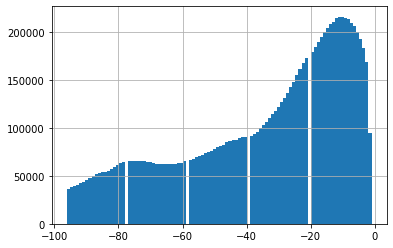

In [ ]:
# 신청월 기준 잔액월 히스토그램
pos_bal['MONTHS_BALANCE'].hist(bins = 100)

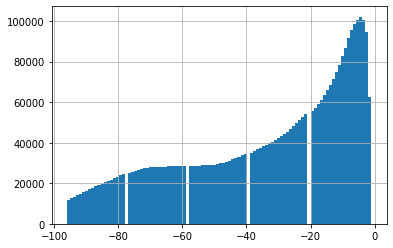

In [ ]:
card_bal['MONTHS_BALANCE'].hist(bins = 100)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


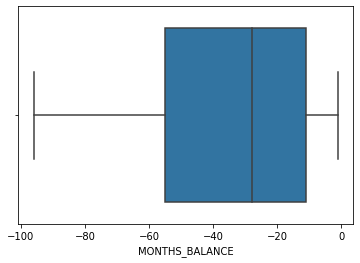

In [ ]:
# 박스플롯에 대한 설명은 김도형의 데이터사이언스 스쿨 552페이지 참조.
sns.boxplot(card_bal['MONTHS_BALANCE'])

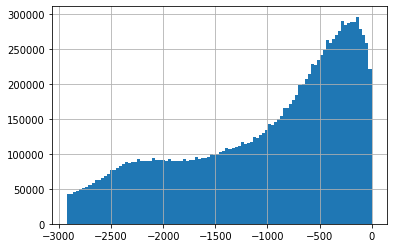

In [ ]:
# 대출 월납입 예정액 히스토그램
install['DAYS_INSTALMENT'].hist(bins=100)

##### BALANCE 데이터 세트에 대한 컬럼 및 Null 조사
* POS_CACHE, INSTALL은 Null값이 많지 않지만, CREDIT_CARD의 경우 인출(DRAWINGS)관련 속성들의 Null값이 많음

In [ ]:
pos_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             uint32 
 1   SK_ID_CURR             uint32 
 2   MONTHS_BALANCE         int32  
 3   CNT_INSTALMENT         float32
 4   CNT_INSTALMENT_FUTURE  float32
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int32  
 7   SK_DPD_DEF             int32  
dtypes: float32(2), int32(3), object(1), uint32(2)
memory usage: 343.4+ MB


In [ ]:
# CNT_INSTALLMENT (대출납부횟수)
# CNT_INSTALMENT_FUTURE (남아있는 대출납부횟수)
# 아쉽게도 널값이 많네.
pos_bal.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

In [ ]:
# NUM_INSTALMENT_VERSION  (대출 납입 변경시 부여되는 버전)
# NUM_INSTALMENT_NUMBER   (대출납입 순번번)
# DAYS_INSTALMENT(대출 월납입액)
# DAYS_ENTRY_PAYMENT(현재 대출 신청 일자 대비 이전 credit가 실제 납부된 일자 )
# AMT_PAYMENT (실제 월납입액)
# AMT_INSTALMENT(대출 월납입 예정액)
install.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              uint32 
 1   SK_ID_CURR              uint32 
 2   NUM_INSTALMENT_VERSION  float32
 3   NUM_INSTALMENT_NUMBER   int32  
 4   DAYS_INSTALMENT         float32
 5   DAYS_ENTRY_PAYMENT      float32
 6   AMT_INSTALMENT          float32
 7   AMT_PAYMENT             float32
dtypes: float32(5), int32(1), uint32(2)
memory usage: 415.2 MB


In [ ]:
install.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [ ]:
card_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  uint32 
 1   SK_ID_CURR                  uint32 
 2   MONTHS_BALANCE              int16  
 3   AMT_BALANCE                 float32
 4   AMT_CREDIT_LIMIT_ACTUAL     int32  
 5   AMT_DRAWINGS_ATM_CURRENT    float32
 6   AMT_DRAWINGS_CURRENT        float32
 7   AMT_DRAWINGS_OTHER_CURRENT  float32
 8   AMT_DRAWINGS_POS_CURRENT    float32
 9   AMT_INST_MIN_REGULARITY     float32
 10  AMT_PAYMENT_CURRENT         float32
 11  AMT_PAYMENT_TOTAL_CURRENT   float32
 12  AMT_RECEIVABLE_PRINCIPAL    float32
 13  AMT_RECIVABLE               float32
 14  AMT_TOTAL_RECEIVABLE        float32
 15  CNT_DRAWINGS_ATM_CURRENT    float32
 16  CNT_DRAWINGS_CURRENT        int32  
 17  CNT_DRAWINGS_OTHER_CURRENT  float32
 18  CNT_DRAWINGS_POS_CURRENT    float32
 19  CNT_INSTALMENT_MATURE

In [ ]:
card_bal.isnull().sum()

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

#### POS_CASH 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교

In [ ]:
# TARGET 값을 가져오기 위해 pos_bal를 apps와 조인

pos_bal_app = pos_bal.merge(apps[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

# 숫자형 컬럼 가져오기 : SK_ID_CURR, TARGET은 제외 
pos_num_columns = pos_bal_app.dtypes[pos_bal_app.dtypes != 'object'].index.to_list()
pos_num_columns = [column for column in pos_num_columns if column not in ['SK_ID_CURR', 'TARGET', 'SK_ID_PREV']]
print(pos_num_columns)

['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF']


In [ ]:
pos_bal_app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10001358 entries, 0 to 10001357
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             uint32 
 1   SK_ID_CURR             uint32 
 2   MONTHS_BALANCE         int32  
 3   CNT_INSTALMENT         float32
 4   CNT_INSTALMENT_FUTURE  float32
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int32  
 7   SK_DPD_DEF             int32  
 8   TARGET                 float64
dtypes: float32(2), float64(1), int32(3), object(1), uint32(2)
memory usage: 496.0+ MB


In [ ]:
def show_hist_by_target(df, columns):
  '''
  타겟 컬럼과 숫자형 피처의 시각화
  '''
  cond_1 = (df['TARGET']== 1) #연체
  cond_0 = (df['TARGET']== 0) #정상

  for column in columns:
    print("column : ", column)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 4), squeeze=False)
    #특정 컬럼이 infinite로 들어가 있는 경우가 문제 발생하여 이를 제거 
    sns.violinplot(x='TARGET', y=column, data = df[np.isfinite(df[column])], ax = axs[0][0])
    sns.distplot(df[cond_1 & np.isfinite(df[column])][column], label = '1', color='red', ax=axs[0][1])
    sns.distplot(df[cond_0 & np.isfinite(df[column])][column], label = '0', color='blue', ax=axs[0][1])

column :  MONTHS_BALANCE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  CNT_INSTALMENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  CNT_INSTALMENT_FUTURE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  SK_DPD


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  SK_DPD_DEF


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


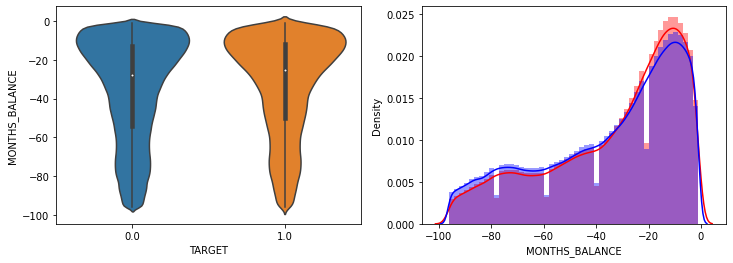

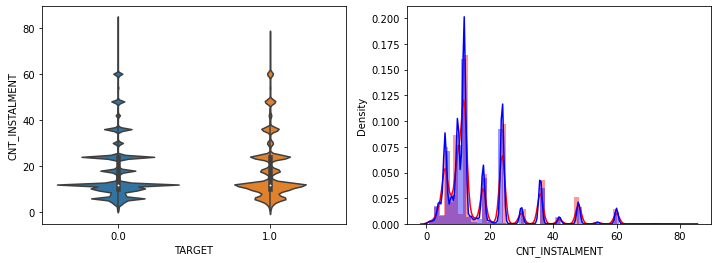

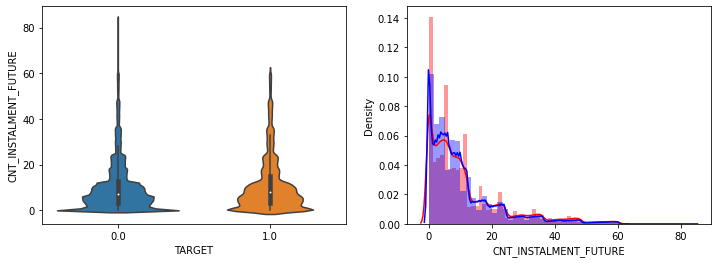

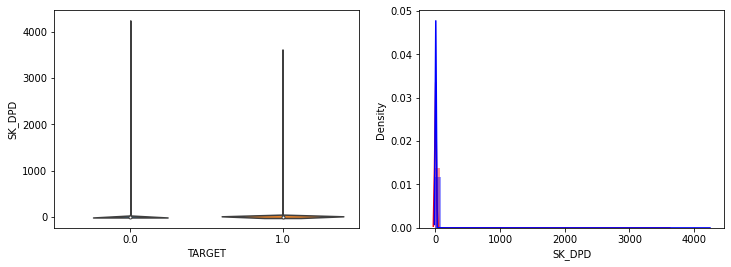

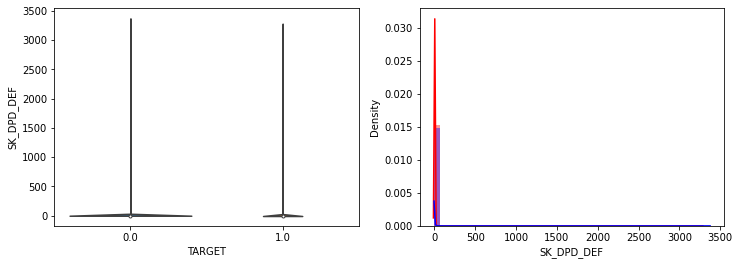

In [ ]:
show_hist_by_target(pos_bal_app, pos_num_columns)

In [ ]:
# 데이터 크기가 커서 Violinplot 시 수행 시간이 오래 걸림. 
def show_hist_by_target_single(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)
    
    for column in columns:
        print("column:", column)
        plt.figure(figsize=(4, 4))
        #fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), squeeze=False)
        # 특정 컬럼값이 infinite로 들어가있는 경우가 있음.  infinite일 경우 KDE histogram 시각화 시 문제 발생하여 이를 제거
        #sns.violinplot(x='TARGET', y=column, data=df[np.isfinite(df[column])], ax=axs[0][0])
        sns.distplot(df[cond_0][column], label='0', color='blue')
        sns.distplot(df[cond_1][column], label='1', color='red')  

column: MONTHS_BALANCE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: CNT_INSTALMENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: CNT_INSTALMENT_FUTURE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: SK_DPD


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column: SK_DPD_DEF


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


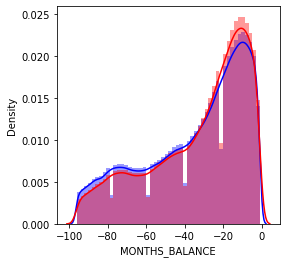

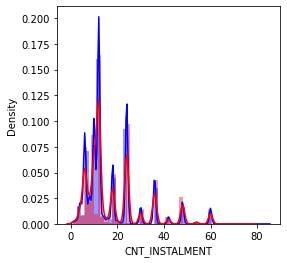

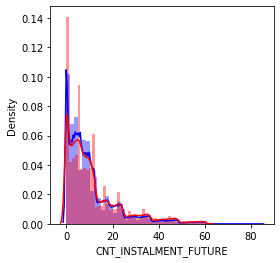

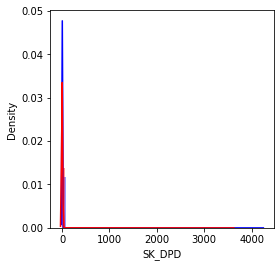

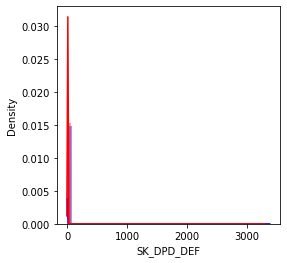

In [ ]:
show_hist_by_target_single(pos_bal_app, pos_num_columns)

#### INSTALLMENTS 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교

In [ ]:
# 타겟값을 가져오기 위해 apps와 조인이 필요
install_app = install.merge(apps[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
install_num_columns = install_app.dtypes[install_app.dtypes != 'object'].index.to_list()

#숫자형 컬럼중 ID와 TARGET은 제외 
install_num_columns = [column for column in install_num_columns if column not in ['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]

column :  NUM_INSTALMENT_VERSION


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  NUM_INSTALMENT_NUMBER


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  DAYS_INSTALMENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  DAYS_ENTRY_PAYMENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_INSTALMENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_PAYMENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


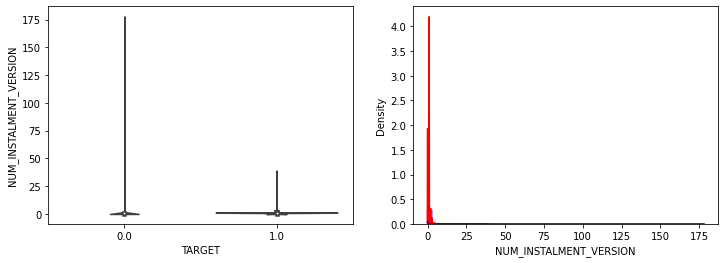

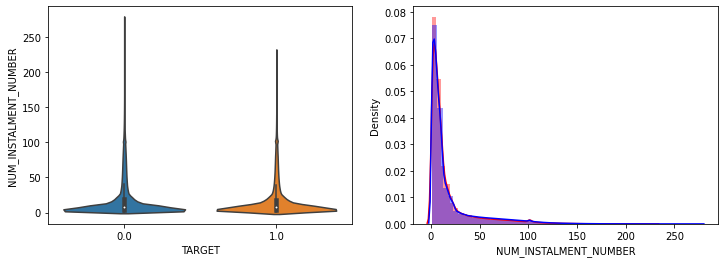

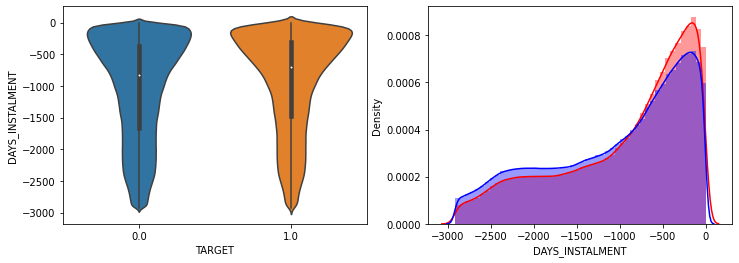

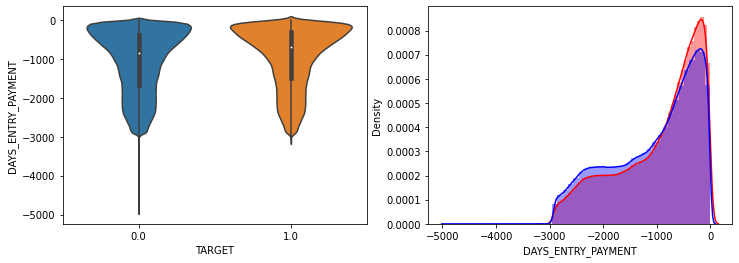

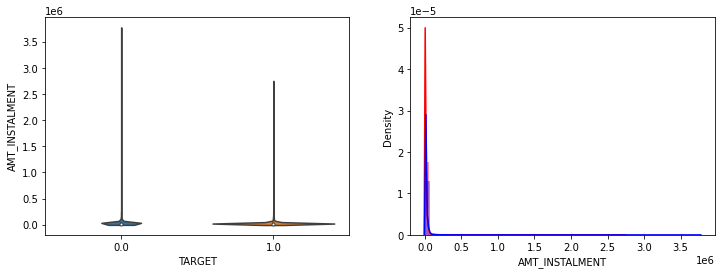

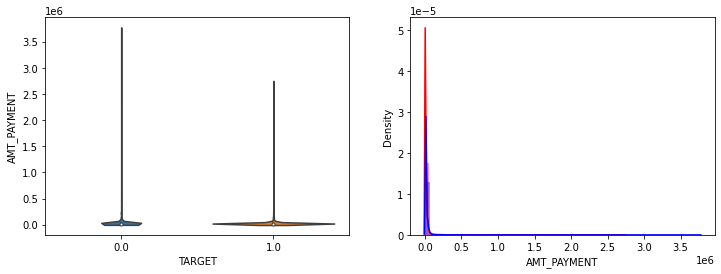

In [ ]:
show_hist_by_target(install_app, install_num_columns)

#### CREDIT_CARD 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교

In [ ]:
# 타겟값을 가져오기 위해 apps와 조인
card_bal_app = card_bal.merge(apps[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

#숫자형 컬럼 추축
card_num_columns = card_bal_app.dtypes[card_bal_app.dtypes != 'object'].index.to_list()

# ID및 TARGET제외
card_num_columns = [column for column in card_num_columns if column not in ['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]
print(card_num_columns)

['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF']


column :  MONTHS_BALANCE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_BALANCE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_CREDIT_LIMIT_ACTUAL


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_DRAWINGS_ATM_CURRENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_DRAWINGS_CURRENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_DRAWINGS_OTHER_CURRENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_DRAWINGS_POS_CURRENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_INST_MIN_REGULARITY


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_PAYMENT_CURRENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_PAYMENT_TOTAL_CURRENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_RECEIVABLE_PRINCIPAL


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_RECIVABLE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  AMT_TOTAL_RECEIVABLE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  CNT_DRAWINGS_ATM_CURRENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  CNT_DRAWINGS_CURRENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  CNT_DRAWINGS_OTHER_CURRENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  CNT_DRAWINGS_POS_CURRENT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  CNT_INSTALMENT_MATURE_CUM


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  SK_DPD


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


column :  SK_DPD_DEF


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


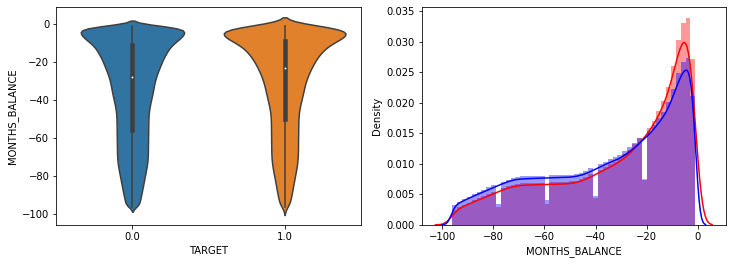

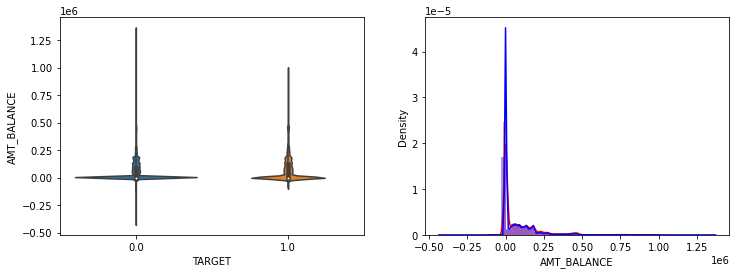

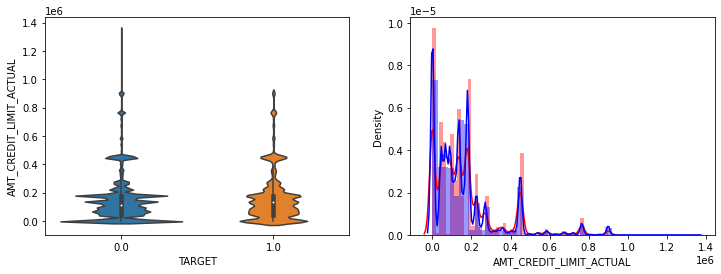

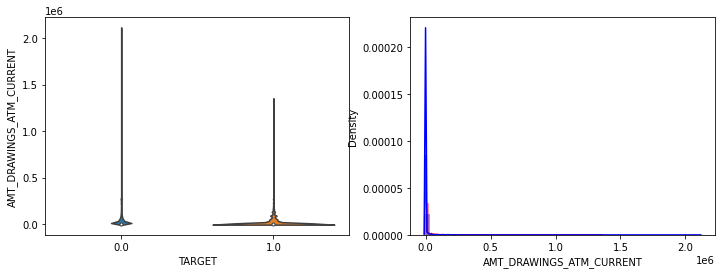

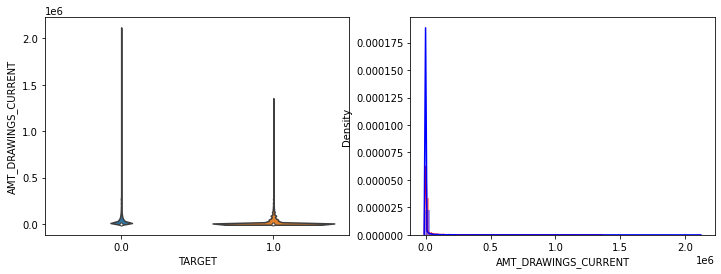

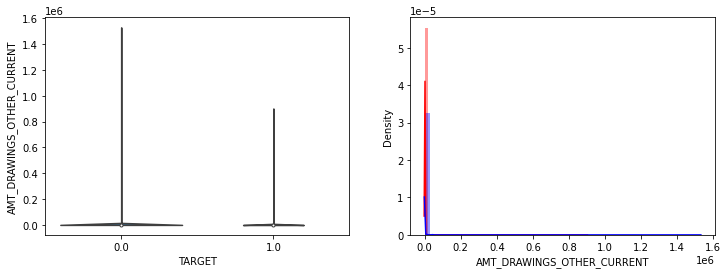

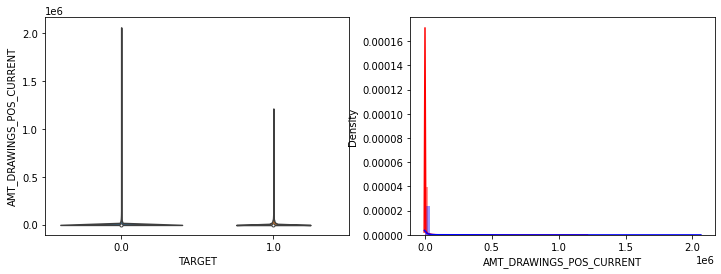

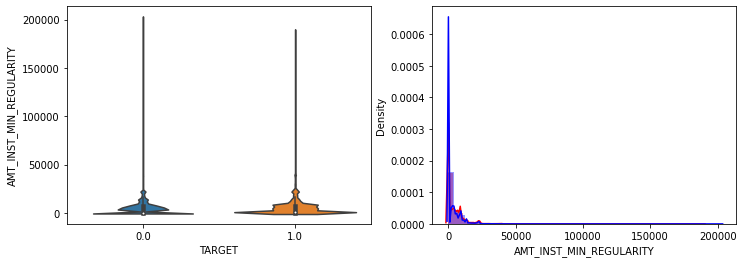

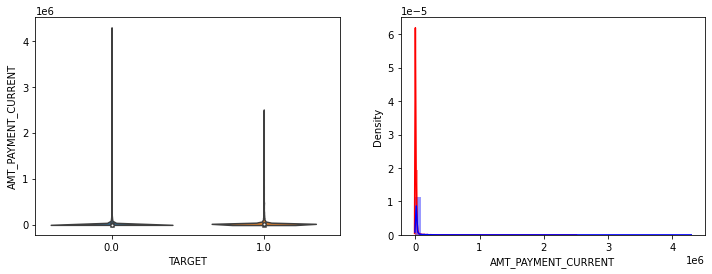

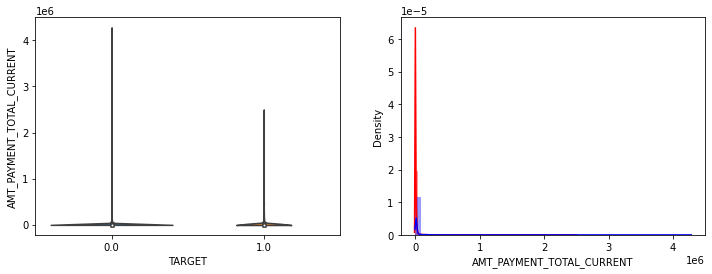

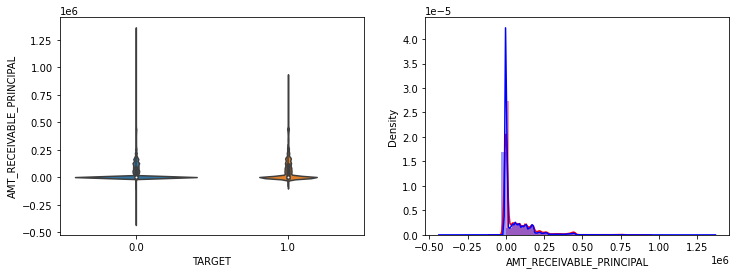

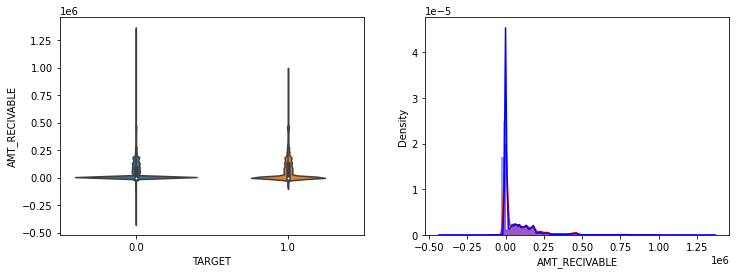

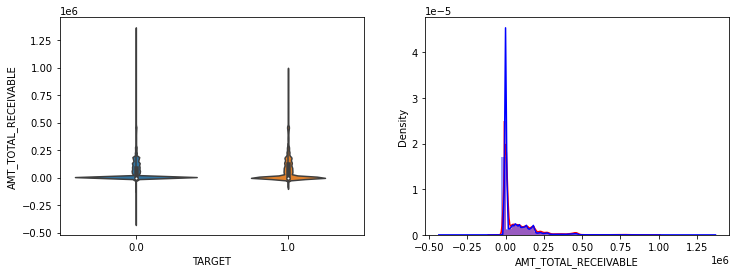

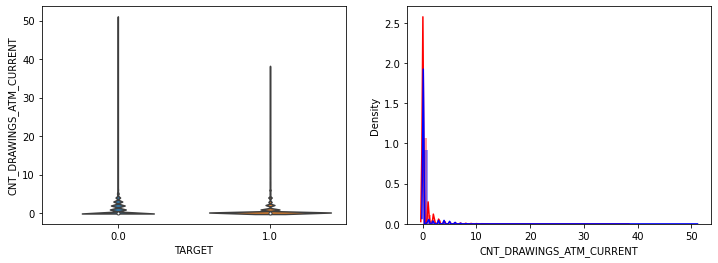

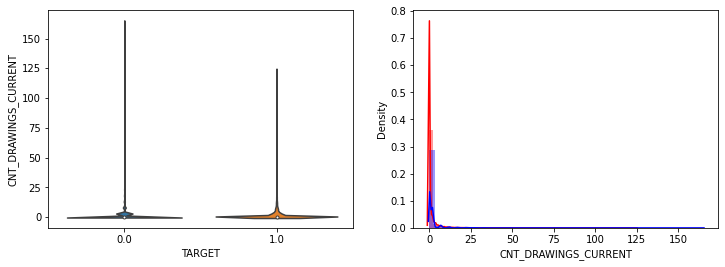

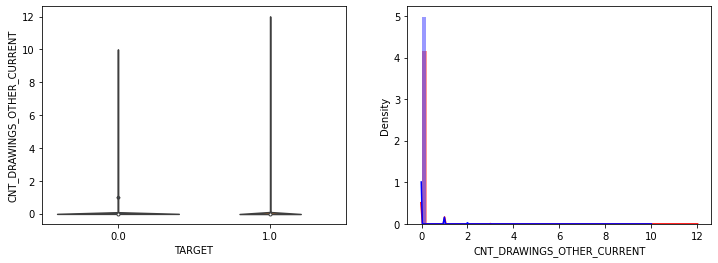

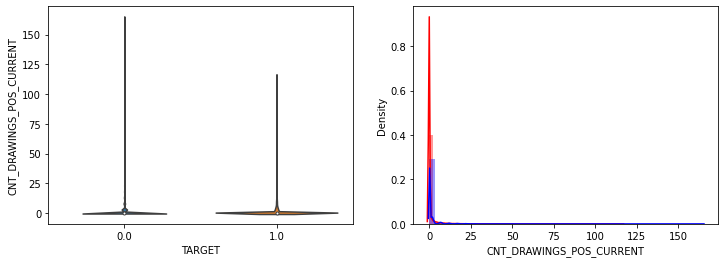

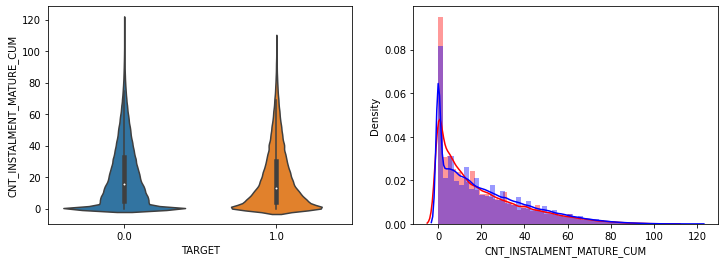

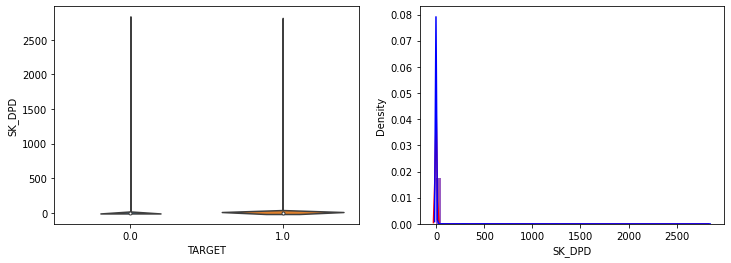

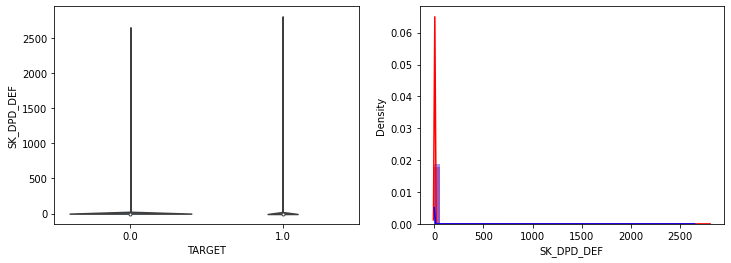

In [ ]:
show_hist_by_target(card_bal_app, card_num_columns)

##### category 컬럼들에 대한 분포도 조사
* NAME_CONTRACT_STATUS 컬럼외에는 category 컬럼이 없음. 
* 데이터셋별로 NAME_CONTRACT_STATUS의 의미가 다르니 유의할것.

In [ ]:
pos_bal['NAME_CONTRACT_STATUS'].value_counts()  # 현 월 대출상태

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [ ]:
card_bal['NAME_CONTRACT_STATUS'].value_counts()  # 계약샹태

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

### POS_CASH_balance  Feature Engineering

##### 연체일자(SK_DPD)에 따른 데이터 가공. 

In [ ]:
pos_bal['SK_DPD'].value_counts()

0       9706131
1         21872
2         17358
3         14403
4         12350
         ...   
3278          1
3280          1
3282          1
3284          1
4231          1
Name: SK_DPD, Length: 3400, dtype: int64

In [ ]:
pos_bal.shape

(10001358, 8)

##### **연체일자를 범위를 주어서 범주화**시키는 중요.

*   연체를 많이 해보았을때 연체 일수가 길어지는 경우 연체로 빠질 확률이 많기 때문에(지극히 개인적)
*   연체일자가 0보다 큰것
*   연체일자가 0보다 크고 30일 이하인것
*   연체일자가 30일보다 크고, 120일보다 작은 것
*   연체일자가 120일 이상인것.

In [ ]:
# 연체 일자(SK_DPD)가 0보다 큰 경우, 0 ~ 30 사이, 30 ~ 120 사이, 120보다 큰 경우
# 연체일수가 길어지면 연체확률이 높기때문에 범위가 의미있는 파생변수 추출 
cond_over_0 = pos_bal['SK_DPD'] > 0 
cond_over_0_30 = (pos_bal['SK_DPD'] > 0 ) & (pos_bal['SK_DPD'] <= 30)
cond_over_30_120 = (pos_bal['SK_DPD'] > 30 ) & (pos_bal['SK_DPD'] < 120)
cond_over_120 = (pos_bal['SK_DPD'] >= 120 )

print("연체비율 : ", pos_bal[cond_over_0].shape[0] / pos_bal.shape[0])
print("30일 미만의 연체비율 : ", pos_bal[cond_over_0_30].shape[0] / pos_bal.shape[0])
print("30일 이상 120일 이하의 연체비율 : ", pos_bal[cond_over_30_120].shape[0] / pos_bal.shape[0])
print("120일 이상의 연체비율 : ", pos_bal[cond_over_120].shape[0] / pos_bal.shape[0])

연체비율 :  0.02951869136171308
30일 미만의 연체비율 :  0.01631468446584954
30일 이상 120일 이하의 연체비율 :  0.0017282653015720465
120일 이상의 연체비율 :  0.011475741594291496


In [ ]:
# 연체여부, 연체 일수 0~ 120일 사이 여부 , 연체일수 120일보다 큰 연체건 여부
pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x :  1 if x > 0 else 0)
pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x :  1 if (x > 0) & (x < 120) else 0)
pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x :  1 if (x >= 120 ) else 0)

In [ ]:
# 연체가 120일 이상인 데이터만 뽑아봄
pos_bal[cond_over_120 ].head(20)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,POS_IS_DPD,POS_IS_DPD_UNDER_120,POS_IS_DPD_OVER_120
2252,2562793,287880,-46,7.0,0.0,Active,1105,0,1,0,1
3507,1290101,322484,-37,6.0,0.0,Active,329,0,1,0,1
3996,2002705,413918,-48,6.0,0.0,Active,146,0,1,0,1
4438,1184431,369596,-44,6.0,0.0,Active,173,0,1,0,1
5234,1526249,275666,-39,12.0,0.0,Active,798,0,1,0,1
5290,2273596,343663,-45,6.0,0.0,Active,143,0,1,0,1
5787,1473810,167948,-40,12.0,0.0,Active,566,0,1,0,1
5788,2749600,365698,-35,12.0,0.0,Active,566,0,1,0,1
5904,1463725,265782,-36,6.0,0.0,Active,324,0,1,0,1
5918,2797839,172911,-39,6.0,0.0,Active,182,0,1,0,1


##### 기존 컬럼과 신규 컬럼으로 SK_ID_CURR 레벨로 신규 aggregation 컬럼 생성. 

In [ ]:
pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
pos_bal_agg_dict = {
    'SK_ID_CURR':['count'],
    'MONTHS_BALANCE':['min', 'mean', 'max'], 
    'SK_DPD':['min', 'max', 'mean'],
    # 가공 컬럼A
    'POS_IS_DPD':['mean', 'sum'],
    'POS_IS_DPD_UNDER_120':['mean', 'sum'],
    'POS_IS_DPD_OVER_120':['mean', 'sum']
}

# SK_ID_CURR레벨로 Aggregation컬럼들 집계 수행
pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)

# column rename
pos_bal_agg.columns = ['POS_'+('_'.join(column)).upper() for column in pos_bal_agg.columns.ravel()]

In [ ]:
pos_bal_agg.head(20)

,POS_SK_ID_CURR_COUNT,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_MAX,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_POS_IS_DPD_MEAN,POS_POS_IS_DPD_SUM,POS_POS_IS_DPD_UNDER_120_MEAN,POS_POS_IS_DPD_UNDER_120_SUM,POS_POS_IS_DPD_OVER_120_MEAN,POS_POS_IS_DPD_OVER_120_SUM
SK_ID_CURR,,,,,,,,,,,,,
100001,9,-96,-72.555556,-53,0,7,0.777778,0.111111,1,0.111111,1,0.000000,0
100002,19,-19,-10.000000,-1,0,0,0.000000,0.000000,0,0.000000,0,0.000000,0
100003,28,-77,-43.785714,-18,0,0,0.000000,0.000000,0,0.000000,0,0.000000,0
100004,4,-27,-25.500000,-24,0,0,0.000000,0.000000,0,0.000000,0,0.000000,0
100005,11,-25,-20.000000,-15,0,0,0.000000,0.000000,0,0.000000,0,0.000000,0
100006,21,-20,-9.619048,-1,0,0,0.000000,0.000000,0,0.000000,0,0.000000,0
100007,66,-77,-33.636364,-1,0,0,0.000000,0.000000,0,0.000000,0,0.000000,0
100008,83,-84,-43.662651,-2,0,1294,339.060241,0.518072,43,0.048193,4,0.469880,39
100009,64,-96,-33.062500,-1,0,0,0.000000,0.000000,0,0.000000,0,0.000000,0


##### POS_CASH_BALANCE에서 MONTHS_BALANCE가 비교적 최근 데이터만 별도로 가공. 
* 연체가 되는 추세가 대출의 남은 월은 최근일때가 높았음을 상기.

In [ ]:
# POS_CASH_BALANCE에서 MONTHS_BALANCE가 비교적 최근 데이터만 별도로 가공
cond_months = pos_bal['MONTHS_BALANCE'] > -20
pos_bal[cond_months].groupby('SK_ID_CURR')['SK_ID_CURR'].count().shape

(272296,)

In [ ]:
pos_bal.groupby('SK_ID_CURR')['SK_ID_CURR'].count().shape

(337252,)

In [ ]:
cond_months = pos_bal['MONTHS_BALANCE'] > -20
pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
pos_bal_agg_dict = {
    'SK_ID_CURR':['count'], 
    'MONTHS_BALANCE':['min', 'mean', 'max'], 
    'SK_DPD':['min', 'max', 'mean'],
    # 가공 컬럼
    'POS_IS_DPD':['mean', 'sum'],
    'POS_IS_DPD_UNDER_120':['mean', 'sum'],
    'POS_IS_DPD_OVER_120':['mean', 'sum']
}

pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_agg_dict)
# 컬럼 변경 
pos_bal_m20_agg.columns = ['POS_M20'+('_'.join(column)).upper() for column in pos_bal_m20_agg.columns.ravel()]

##### pos_bal_agg와 pos_bal_m20_agg를 조인하고 SK_ID_CURR을 reset_index()를 이용하여 컬럼으로 변환

In [ ]:
pos_bal_agg.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 337252 entries, 100001 to 456255
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   POS_SK_ID_CURR_COUNT           337252 non-null  int64  
 1   POS_MONTHS_BALANCE_MIN         337252 non-null  int32  
 2   POS_MONTHS_BALANCE_MEAN        337252 non-null  float64
 3   POS_MONTHS_BALANCE_MAX         337252 non-null  int32  
 4   POS_SK_DPD_MIN                 337252 non-null  int32  
 5   POS_SK_DPD_MAX                 337252 non-null  int32  
 6   POS_SK_DPD_MEAN                337252 non-null  float64
 7   POS_POS_IS_DPD_MEAN            337252 non-null  float64
 8   POS_POS_IS_DPD_SUM             337252 non-null  int64  
 9   POS_POS_IS_DPD_UNDER_120_MEAN  337252 non-null  float64
 10  POS_POS_IS_DPD_UNDER_120_SUM   337252 non-null  int64  
 11  POS_POS_IS_DPD_OVER_120_MEAN   337252 non-null  float64
 12  POS_POS_IS_DPD_OVER_120_

In [ ]:
pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')

In [ ]:
pos_bal_agg = pos_bal_agg.reset_index()

In [ ]:
pos_bal_agg.shape  # 27개의 컬럼럼

(337252, 27)

In [ ]:
def get_pos_bal_agg(pos_bal):
  """
  pos_bal_agg와 pos_bal_m20_agg를 조인해서 리턴
  """
  cond_months = pos_bal['MONTHS_BALANCE'] > -20
  pos_bal_grp = pos_bal.groupby('SK_ID_CURR')  
  pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')

  pos_bal_agg_dict = {
      'SK_ID_CURR':['count'],
      'MONTHS_BALANCE':['min', 'mean', 'sum'],
      'SK_DPD':['min', 'mean', 'sum'],
      #가공컬럼
      'POS_IS_DPD':['mean', 'sum'],
      'POS_IS_DPD_UNDER_120':['mean', 'sum'],
      'POS_IS_DPD_OVER_120':['mean', 'sum']
  }
  # SK_ID_CURR레벨로 Aggregation 컬럼들 aggregation groupby 수행.   
  pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)
  #컬럼 변경
  pos_bal_agg.columns = ['POS_'+ ('_'.join(column)).upper() for column in pos_num_columns.ravel()]

  pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_agg_dict)
  # 컬럼 변경 
  pos_bal_m20_agg.columns = ['POS_M20'+('_'.join(column)).upper() for column in pos_bal_m20_agg.columns.ravel()]

  pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, how='left', on = 'SK_ID_CURR')
  pos_bal_agg = pos_bal_agg.reset_index()

  return pos_bal_agg

### installments_payments 데이터 가공.

* 예정 납부 금액 대비 실제 납부 금액 관련 데이터 가공. 
* 예정 납부 일자 대비 실제 납부 일자 비교로  DPD 일자 생성 

In [ ]:
install.head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375000,5970.375000
6,2234264,184693,4.0,11,-349.0,-352.0,29432.294922,29432.294922
7,1818599,111420,2.0,4,-968.0,-994.0,17862.164062,17862.164062
8,2723183,112102,0.0,14,-197.0,-197.0,70.739998,70.739998
9,1413990,109741,1.0,4,-570.0,-609.0,14308.469727,14308.469727


In [ ]:
# 실 대출금액에 대한 납부금액과 예정 납부금액의 차이도 
# 당연히 연체에 영향 줄수있고, 또한 대출 월납입 예정액에 대한 실제 납입 비율도 중요한 팩터이다.

# 예정 납부 금액과 실제 납부 금액 차이와 비율 가공

# AMT_INSTALMENT - 대출월납입 예정액
# AMT_PAYMENT    - 실제 월납입액
install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
install['AMT_RATIO'] = (install['AMT_PAYMENT'] + 1) / (install['AMT_INSTALMENT'] + 1) 

# 예정 납부 일자 대비 실제 납부 일자 비교로  DPD 일자 생성  
# 납부예정일 - 20210320(DAYS_ENTRY_PAYMENT) , 실제납부일 - 20210324(DAYS_INSTALMENT) , 이 두 값의 차가 연체일
install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']  # 실제납부일자 - 예정된 납부일자(연체일자)
install.head(20)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMT_DIFF,AMT_RATIO,SK_DPD,INS_IS_DPD,INS_IS_DPD_UNDER_120,INS_IS_DPD_OVER_120
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863,0.000000,1.000000,-7.0,0,0,0
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024,0.000000,1.000000,0.0,0,0,0
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000,0.000000,1.000000,0.0,0,0,0
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859,0.000000,1.000000,-8.0,0,0,0
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961,4.455078,0.997943,17.0,1,1,0
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375000,5970.375000,0.000000,1.000000,-33.0,0,0,0
6,2234264,184693,4.0,11,-349.0,-352.0,29432.294922,29432.294922,0.000000,1.000000,-3.0,0,0,0
7,1818599,111420,2.0,4,-968.0,-994.0,17862.164062,17862.164062,0.000000,1.000000,-26.0,0,0,0
8,2723183,112102,0.0,14,-197.0,-197.0,70.739998,70.739998,0.000000,1.000000,0.0,0,0,0
9,1413990,109741,1.0,4,-570.0,-609.0,14308.469727,14308.469727,0.000000,1.000000,-39.0,0,0,0


###### 연체 일자(SK_DPD)가 0 보다 큰 경우, 30-120 사이, 120보다 큰 경우 조사 

In [ ]:
# 연체 일자(SK_DPD)가 0 보다 큰 경우, 30-120 사이, 120보다 큰 경우 조사 
cond_over_0 = install['SK_DPD'] > 0
cond_over_0_30 = (install['SK_DPD'] <= 30) & (install['SK_DPD'] > 0)
cond_over_30_120 = (install['SK_DPD'] < 120) & (install['SK_DPD'] > 30)
cond_over_120 = (install['SK_DPD'] >= 120)

print(' 연체 비율:', install[cond_over_0].shape[0]/install.shape[0] )
print(' 연체 비율 30일 미만:', install[cond_over_0_30].shape[0]/install.shape[0] )
print(' 연체일자 30일이상 120이하 비율 :', install[cond_over_30_120].shape[0]/install.shape[0] )
print(' 연체일자 120이상 비율 :', install[cond_over_120].shape[0]/install.shape[0] )

 연체 비율: 0.08428042657471103
 연체 비율 30일 미만: 0.08144023097885905
 연체일자 30일이상 120이하 비율 : 0.002042791682509027
 연체일자 120이상 비율 : 0.0007974039133429437


##### 연체여부,  연체일수 0~ 120 사이 여부, 연체 일수 120보다 큰 여부 가공. 

In [ ]:
# 연체여부,  연체일수 0~ 120 사이 여부, 연체 일수 120보다 큰 여부 
install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

In [ ]:
install.head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMT_DIFF,AMT_RATIO,SK_DPD,INS_IS_DPD,INS_IS_DPD_UNDER_120,INS_IS_DPD_OVER_120
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863,0.000000,1.000000,-7.0,0,0,0
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024,0.000000,1.000000,0.0,0,0,0
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000,0.000000,1.000000,0.0,0,0,0
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859,0.000000,1.000000,-8.0,0,0,0
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961,4.455078,0.997943,17.0,1,1,0
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375000,5970.375000,0.000000,1.000000,-33.0,0,0,0
6,2234264,184693,4.0,11,-349.0,-352.0,29432.294922,29432.294922,0.000000,1.000000,-3.0,0,0,0
7,1818599,111420,2.0,4,-968.0,-994.0,17862.164062,17862.164062,0.000000,1.000000,-26.0,0,0,0
8,2723183,112102,0.0,14,-197.0,-197.0,70.739998,70.739998,0.000000,1.000000,0.0,0,0,0
9,1413990,109741,1.0,4,-570.0,-609.0,14308.469727,14308.469727,0.000000,1.000000,-39.0,0,0,0


In [ ]:
install_grp = install.groupby('SK_ID_CURR')

install_agg_dict = {
    'SK_ID_CURR':['count'],
    'NUM_INSTALMENT_VERSION':['nunique'], 
    'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],  # 예정된 납부일자
    'DAYS_INSTALMENT':['mean', 'max', 'sum'],     # 실제 납부일자
    'AMT_INSTALMENT':['mean', 'max', 'sum'],      # 예정 대출납입액
    'AMT_PAYMENT':['mean', 'max','sum'],      # 실제 대출납입액
    # 추가 컬럼
    'AMT_DIFF':['mean','min', 'max','sum'],
    'AMT_RATIO':['mean', 'max'],
    'SK_DPD':['mean', 'min', 'max'],
    'INS_IS_DPD':['mean', 'sum'],  # 연체 
    'INS_IS_DPD_UNDER_120':['mean', 'sum'], # 120일 미만 연체
    'INS_IS_DPD_OVER_120':['mean', 'sum']      # 120일 이상 연체
}
# SK_ID_CURR레벨로 Aggregation 컬럼들 aggregation groupby 수행.   
install_agg = install_grp.agg(install_agg_dict)
# aggregation된 새로운 컬럼들에 컬럼명 생성. 
install_agg.columns = ['INS_'+('_'.join(column)).upper() for column in install_agg.columns.ravel()]
install_agg.head()

,INS_SK_ID_CURR_COUNT,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_SUM,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_INSTALMENT_MAX,INS_DAYS_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_SUM,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_SUM,INS_AMT_DIFF_MEAN,INS_AMT_DIFF_MIN,INS_AMT_DIFF_MAX,INS_AMT_DIFF_SUM,INS_AMT_RATIO_MEAN,INS_AMT_RATIO_MAX,INS_SK_DPD_MEAN,INS_SK_DPD_MIN,INS_SK_DPD_MAX,INS_INS_IS_DPD_MEAN,INS_INS_IS_DPD_SUM,INS_INS_IS_DPD_UNDER_120_MEAN,INS_INS_IS_DPD_UNDER_120_SUM,INS_INS_IS_DPD_OVER_120_MEAN,INS_INS_IS_DPD_OVER_120_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,7,2,-2195.000000,-1628.0,-15365.0,-2187.714355,-1619.0,-15314.0,5885.132324,17397.900391,4.119593e+04,5885.132324,17397.900391,4.119593e+04,0.0,0.0,0.0,0.0,1.0,1.0,-7.285714,-36.0,11.0,0.142857,1,0.142857,1,0.0,0
100002,19,2,-315.421051,-49.0,-5993.0,-295.000000,-25.0,-5605.0,11559.247070,53093.746094,2.196257e+05,11559.247070,53093.746094,2.196257e+05,0.0,0.0,0.0,0.0,1.0,1.0,-20.421053,-31.0,-12.0,0.000000,0,0.000000,0,0.0,0
100003,25,2,-1385.319946,-544.0,-34633.0,-1378.160034,-536.0,-34454.0,64754.585938,560835.375000,1.618865e+06,64754.585938,560835.375000,1.618865e+06,0.0,0.0,0.0,0.0,1.0,1.0,-7.160000,-14.0,-1.0,0.000000,0,0.000000,0,0.0,0
100004,3,2,-761.666687,-727.0,-2285.0,-754.000000,-724.0,-2262.0,7096.154785,10573.964844,2.128846e+04,7096.154785,10573.964844,2.128846e+04,0.0,0.0,0.0,0.0,1.0,1.0,-7.666667,-11.0,-3.0,0.000000,0,0.000000,0,0.0,0
100005,9,2,-609.555542,-470.0,-5486.0,-586.000000,-466.0,-5274.0,6240.205078,17656.244141,5.616184e+04,6240.205078,17656.244141,5.616184e+04,0.0,0.0,0.0,0.0,1.0,1.0,-23.555555,-37.0,1.0,0.111111,1,0.111111,1,0.0,0


##### 실제 납부 일자(DAYS_ENTRY_PAYMENT)가 비교적 최근(1년 이내) 데이터만 별도로 가공. 

In [ ]:
# DAYS_ENTRY_PAYMENT가 비교적 최근(1년 이내) 데이터만 추출. 
cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
install_d365_grp = install[cond_day].groupby('SK_ID_CURR')

install_d365_agg_dict = {
    'SK_ID_CURR':['count'],
    'NUM_INSTALMENT_VERSION':['nunique'], 
    'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
    'DAYS_INSTALMENT':['mean', 'max', 'sum'],
    'AMT_INSTALMENT':['mean', 'max', 'sum'],
    'AMT_PAYMENT':['mean', 'max','sum'],
    #  추가 컬럼
    'AMT_DIFF':['mean','min', 'max','sum'],
    'AMT_RATIO':['mean', 'max'],
    'SK_DPD':['mean', 'min', 'max'],
    'INS_IS_DPD':['mean', 'sum'],
    'INS_IS_DPD_UNDER_120':['mean', 'sum'],
    'INS_IS_DPD_OVER_120':['mean', 'sum']    
}
# SK_ID_CURR레벨로 Aggregation 컬럼들 aggregation groupby 수행.      
install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
# aggregation된 새로운 컬럼들에 컬럼명 생성. 
install_d365_agg.columns = ['INS_D365'+('_'.join(column)).upper() for column in install_d365_agg.columns.ravel()]

##### install_agg과 새로 생성한 install_d365_agg를 조인하고 SK_ID_CURR을 reset_index()를 이용하여 컬럼으로 변환

In [ ]:
install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
install_agg = install_agg.reset_index()

In [ ]:
install_agg.shape

(339587, 59)

### credit_card_balance 데이터 가공
* 월별 카드 허용한도에 따른 잔고와 인출 금액 비율 
* DPD에 따른 가공

In [ ]:
card_bal.isnull().sum()  # 널값이 비교적 많다(인출관련 필드)

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

##### 월별 카드 허용한도에 따른 잔고와 인출 금액 비율 

In [ ]:
# 아래의 3가지 파생변수가 연체에 주요한 변수임을 알수있음.

# AMT_BALANCE(월별 잔액)
# AMT_CREDIT_LIIT_ACTUAL(월별카드허용한도)
# AMT_DRAWINGS_CURRENT(월별인출금액)
card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

##### DPD에 따른 가공 컬럼 생성.
* 연체일을 아는 것이 매울 중요.

In [ ]:
# 연체 일자(SK_DPD)가 0 보다 큰 경우, 30-120 사이, 120보다 큰 경우 조사 
cond_over_0 = card_bal['SK_DPD'] > 0
cond_over_0_30 = (card_bal['SK_DPD'] <= 30) & (card_bal['SK_DPD'] > 0)
cond_over_30_120 = (card_bal['SK_DPD'] < 120) & (card_bal['SK_DPD'] > 30)
cond_over_120 = (card_bal['SK_DPD'] >= 120)

print(' 연체 비율:', card_bal[cond_over_0].shape[0]/card_bal.shape[0] )
print(' 연체 비율 30일 미만:', card_bal[cond_over_0_30].shape[0]/card_bal.shape[0] )
print(' 연체일자 30일이상 120이하 비율 :', card_bal[cond_over_30_120].shape[0]/card_bal.shape[0] )
print(' 연체일자 120이상 비율 :', card_bal[cond_over_120].shape[0]/card_bal.shape[0] )

 연체 비율: 0.039932953364205825
 연체 비율 30일 미만: 0.025626303279525205
 연체일자 30일이상 120이하 비율 : 0.0022019044285985097
 연체일자 120이상 비율 : 0.01210474565608211


In [ ]:
# 연체여부,  연체일수 0~ 120 사이 여부, 연체 일수 120보다 큰 여부 추가 가공. 
card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

In [ ]:
card_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,BALANCE_LIMIT_RATIO,DRAWING_LIMIT_RATIO,CARD_IS_DPD,CARD_IS_DPD_UNDER_120,CARD_IS_DPD_OVER_120
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0,0.000422,0.00650,0,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0,1.421679,0.05000,0,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0,0.070700,0.00000,0,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0,1.051432,0.01000,0,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0,1.008710,0.02566,0,0,0


##### 기존 컬럼과 가공 컬럼으로 SK_ID_CURR 레벨로 aggregation 신규 컬럼 생성. 

In [ ]:
# 기존 컬럼과 가공 컬럼으로 SK_ID_CURR 레벨로 aggregation 신규 컬럼 생성. 
card_bal_grp = card_bal.groupby('SK_ID_CURR')
card_bal_agg_dict = {
    'SK_ID_CURR':['count'],
     #'MONTHS_BALANCE':['min', 'max', 'mean'],
    'AMT_BALANCE':['max'],
    'AMT_CREDIT_LIMIT_ACTUAL':['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],
    #  추가 컬럼
    'BALANCE_LIMIT_RATIO':['min','max'],
    'DRAWING_LIMIT_RATIO':['min', 'max'],
    'CARD_IS_DPD':['mean', 'sum'],
    'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
    'CARD_IS_DPD_OVER_120':['mean', 'sum']    
}
# SK_ID_CURR레벨로 Aggregation 컬럼들 aggregation groupby 수행.  
card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
# aggregation된 새로운 컬럼들에 컬럼명 생성. 
card_bal_agg.columns = ['CARD_'+('_'.join(column).upper()) for column in card_bal_agg.columns.ravel()]

##### MONTHS_BALANCE가 비교적 최근 데이터( 3개월 이하)만 별도로 가공. 

In [ ]:
# MONTHS_BALANCE가 3개월 이하 최신 데이터만 별도로 가공. 
# 앞의 시각화에서보듯 초기의 MONTHS_BALANCE가 연체율이 높은것을 알수있다.
# 초기의 기준으로 피처생성
cond_month = card_bal['MONTHS_BALANCE'] >= -3
card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')

card_bal_agg_dict = {
    'SK_ID_CURR':['count'],
     #'MONTHS_BALANCE':['min', 'max', 'mean'],
    'AMT_BALANCE':['max'],
    'AMT_CREDIT_LIMIT_ACTUAL':['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],
    #  추가 컬럼
    'BALANCE_LIMIT_RATIO':['min','max'],
    'DRAWING_LIMIT_RATIO':['min', 'max'],
    'CARD_IS_DPD':['mean', 'sum'],
    'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
    'CARD_IS_DPD_OVER_120':['mean', 'sum']    
}
# SK_ID_CURR레벨로 Aggregation 컬럼들 aggregation groupby 수행.
card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
# aggregation된 새로운 컬럼들에 컬럼명 생성. 
card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]

##### card_bal_agg와 새로 생성한 card_bal_m3_agg를 조인하고 SK_ID_CURR을 reset_index()를 이용하여 컬럼으로 변환

In [ ]:
card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
card_bal_agg = card_bal_agg.reset_index()

##### 새롭게 생성한 aggregation 데이터 세트에 대한 shape 

In [ ]:
print('pos_bal_agg shape:', pos_bal_agg.shape, 'install_agg shape:', install_agg.shape, 'card_bal_agg shape:', card_bal_agg.shape)

pos_bal_agg shape: (337252, 27) install_agg shape: (339587, 29) card_bal_agg shape: (103558, 69)


#### 지금까지 수행한 POS_CASH, INSTALL, CREDIT_CARD에 대한 FE를 별도의 함수로 생성.

In [ ]:
def get_pos_bal_agg(pos_bal):
    # 연체 일자(SK_DPD)가 0 보다 큰 경우, 0~ 100 사이, 100보다 큰 경우 조사 
    cond_over_0 = pos_bal['SK_DPD'] > 0
    cond_100 = (pos_bal['SK_DPD'] < 100) & (pos_bal['SK_DPD'] > 0)
    cond_over_100 = (pos_bal['SK_DPD'] >= 100)

    # 연체여부,  연체일수 0~ 120 사이 여부, 연체 일수 120보다 큰 여부 
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 신규 컬럼으로 SK_ID_CURR 레벨로 신규 aggregation 컬럼 생성
    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        # 추가 컬럼. 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)
    # 컬럼명 변경 
    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]
    
    # MONTHS_BALANCE가 최근(20개월 이하)인 데이터 세트 별도 가공. 
    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m20_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        # 추가 컬럼. 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_m20_agg_dict)
    # 컬럼 변경 
    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')
    
    # SK_ID_CURR을 reset_index()를 이용하여 컬럼으로 변환
    pos_bal_agg = pos_bal_agg.reset_index()
    
    
    return pos_bal_agg

def get_install_agg(install):
    # 예정 납부 금액 대비 실제 납부 금액 관련 데이터 가공. 예정 납부 일자 대비 실제 납부 일자 비교를 DPD 일자 생성  
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1)
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

    # 연체여부,  연체일수 30~ 120 사이 여부, 연체 일수 100보다 큰 여부 데이터 가공. 
    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 신규 컬럼으로 SK_ID_CURR 레벨로 신규 aggregation 컬럼 생성. 
    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],
        #  추가 컬럼
        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]

    
    # 실제 납부 일자(DAYS_ENTRY_PAYMENT)가 비교적 최근(1년 이내) 데이터만 별도로 가공
    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],
        #  추가 컬럼
        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }
    
    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]
    
    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()
    
    return install_agg

def get_card_bal_agg(card_bal):
    # 월별 카드 허용한도에 따른 잔고와 인출 금액 비율 
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    # DPD에 따른 가공 컬럼 생성.
    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 가공 컬럼으로 SK_ID_CURR 레벨로 aggregation 신규 컬럼 생성. 
    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
         #'MONTHS_BALANCE':['min', 'max', 'mean'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],
        #  추가 컬럼
        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']    
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()
    
    # MONTHS_BALANCE가 비교적 최근 데이터( 3개월 이하)만 별도로 가공.  
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg

In [ ]:
# 메모리 줄이기 위해 함.
del pos_bal_app, install_app, card_bal_app, pos_bal_agg, install_agg, card_bal_agg
gc.collect()

In [ ]:
pos_bal_agg = get_pos_bal_agg(pos_bal)
install_agg = get_install_agg(install)
card_bal_agg = get_card_bal_agg(card_bal)

print('pos_bal_agg shape:', pos_bal_agg.shape, 'install_agg shape:', install_agg.shape, 'card_bal_agg shape:', card_bal_agg.shape)

pos_bal_agg shape: (337252, 45) install_agg shape: (339587, 59) card_bal_agg shape: (103558, 70)


### 기존 application, previous, bureau, bureau_bal 데이터 가공 로직 복사. 

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

def get_apps_processed(apps):
  """
  현 대출정보에 대한 피처 가공 
  """  
  # EXT_SOURCE_X FEATURE 가공
  apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
  apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
  apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
  
  # AMT_CREDIT 비율로 Feature 가공
  # AMT_ANNUITY (월대출지급액)
  # AMT_CREDIT (대출금액)
  # AMT_GOODS_PRICE(소비자대출상품액)
  apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
  apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
  
  # AMT_INCOME_TOTAL 비율로 Feature 가공
  # AMT_INCOME_TOTAL(소득)
  # CNT_FAM_MEMBERS(가족수)
  apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
  apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
  apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
  apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
  
  # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
  apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
  apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
  apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
  apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
  apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
  
  return apps

def get_prev_processed(prev):
  """
  이전 대출정보에 대한 피처 가공 
  """
  # 대출 신청 금액(AMT_APPLICATION)과 실제 대출액(AMT_CREDIT)/대출 상품금액(AMT_GOODS_PRICE) 차이 및 비율

  prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
  prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
  prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
  # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
  prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
  
  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
  prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
  # 첫번째 만기일과 마지막 만기일까지의 기간
  prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
  # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함. 
  all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
  # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산. 
  prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
      
  return prev
    
    
def get_prev_amt_agg(prev):
    # 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행. 
    agg_dict = {
         # 기존 컬럼 aggregation. 
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 가공 컬럼 aggregation
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    return prev_amt_agg

def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    # 컬럼명 변경. 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    # NaN값은 모두 0으로 변경. 
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    
    return prev_refused_appr_agg

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

# bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 컬럼 가공.
def get_bureau_processed(bureau):
    # 예정 채무 시작 및 완료일과 실제 채무 완료일간의 차이 및 날짜 비율 가공.  
    # DAYS_CREDIT_ENDDATE(CB 크레딧 채무 완료까지 남아있는 일수(신청일 기준))
    # DAYS_ENDDATE_FACT(CB 크레딧 채무 완료까지 걸린 실제 일수)
    # DAYS_CREDIT(현재대출신청일기준 과거 대출신청이 지난 기간)
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    # 채무 금액 대비/대출 금액 비율 및 차이 가공
    # AMT_CREDIT_SUM_DEBT(현재 채무금액총액)
    # AMT_CREDIT_SUM(현재 크래딧금액총액)
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
    
    # 연체 여부 및 120일 이상 연체 여부 가공
    # CREDIT_DAY_OVERDUE(대출신청시 CB크래딧 연체일수)
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

# bureau 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성. 
def get_bureau_day_amt_agg(bureau):
        
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    # 추가 가공 컬럼
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

# Bureau의 CREDIT_ACTIVE='Active' 인 데이터만 filtering 후 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성
def get_bureau_active_agg(bureau):
    # CREDIT_ACTIVE='Active' 인 데이터만 filtering
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        # 추가 가공 컬럼
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_active_agg = bureau_active_agg.reset_index()
    #print('bureau_active_agg shape:', bureau_active_agg.shape)
    return bureau_active_agg

# bureau_bal을 SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
def get_bureau_bal_agg(bureau, bureau_bal):
    # SK_ID_CURR레벨로 Group by하기 위해 bureau에서 SK_ID_CURR 컬럼을 가져오는 조인 수행. 
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    
    # STATUS에 따라 월별 연체 여부 및 120일 이상 연체 여부 속성 가공. 
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_bal_agg = bureau_bal_agg.reset_index()
    #print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg
    
# 가공된 bureau관련 aggregation 컬럼들을 모두 결합   
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    
    # bureau_day_amt_agg와 bureau_active_agg 조인.  
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    # STATUS가 ACTIVE IS_DPD RATIO관련 비율 재가공. 
    #bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    #bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    
    # bureau_agg와 bureau_bal_agg 조인. 
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

    #print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg

def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

def get_apps_all_encoded(apps_all):
  """
  범주형 컬럼 인코딩
  """  
  object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
  for column in object_columns:
      apps_all[column] = pd.factorize(apps_all[column])[0]
  
  return apps_all

def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test
    
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=2000,
                learning_rate=0.02,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                )
   
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 200)
    
    return clf

#### 지금까지 개별 테이블 별로 데이터 가공한 모든 데이터 세트들을 조인 결합. 

In [ ]:
# apps와 prev_agg, bureau_agg, pos_bal_agg, install_agg, card_bal_agg를 개별 함수 호출하여 생성후 조인 결합
def get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    bureau_agg = get_bureau_agg(bureau, bureau_bal)
    pos_bal_agg = get_pos_bal_agg(pos_bal)
    install_agg = get_install_agg(install)
    card_bal_agg = get_card_bal_agg(card_bal)
    print('prev_agg shape:', prev_agg.shape, 'bureau_agg shape:', bureau_agg.shape )
    print('pos_bal_agg shape:', pos_bal_agg.shape, 'install_agg shape:', install_agg.shape, 'card_bal_agg shape:', card_bal_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    
    # 생성된 prev_agg, bureau_agg, pos_bal_agg, install_agg, card_bal_agg를 apps와 조인하여 최종 학습/테스트 집합 생성. 
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(pos_bal_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(install_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(card_bal_agg, on='SK_ID_CURR', how='left')
    
    print('apps_all after merge with all shape:', apps_all.shape)
    
    return apps_all

##### 원본 데이터 세트 재 로딩.

In [ ]:
def get_dataset():
    app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
    app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))
    apps = pd.concat([app_train, app_test])
    
    prev = pd.read_csv(os.path.join(default_dir,'previous_application.csv'))
    bureau = pd.read_csv(os.path.join(default_dir,'bureau.csv'))
    bureau_bal = pd.read_csv(os.path.join(default_dir,'bureau_balance.csv'))
    
    pos_bal, install, card_bal = get_balance_data()
        
    return apps, prev, bureau, bureau_bal, pos_bal, install, card_bal

In [ ]:
del apps, pos_bal, install, card_bal
gc.collect()

150

In [ ]:
apps, prev, bureau, bureau_bal, pos_bal, install, card_bal = get_dataset()

##### 모든 데이터 가공, 인코딩, 학습/테스트 데이터 분리, 학습 수행. 

In [ ]:
# application, previous, bureau, bureau_bal 관련 데이터셋 가공 및 취합. 
apps_all = get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal)

# Category 컬럼을 모두 Label 인코딩 수행. 
apps_all = get_apps_all_encoded(apps_all)

# 학습과 테스트 데이터로 분리. 
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

#학습수행. 
clf = train_apps_all(apps_all_train)

'''
Private Score: 0.78926, Public Score:0.80134
'''

prev_agg shape: (338857, 41) bureau_agg shape: (305811, 103)
pos_bal_agg shape: (337252, 45) install_agg shape: (339587, 59) card_bal_agg shape: (103558, 70)
apps_all before merge shape: (356255, 135)
apps_all after merge with all shape: (356255, 449)
train shape: (215257, 447) valid shape: (92254, 447)
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.238681	training's auc: 0.79644	valid_1's binary_logloss: 0.244924	valid_1's auc: 0.770142
[200]	training's binary_logloss: 0.22709	training's auc: 0.820548	valid_1's binary_logloss: 0.23906	valid_1's auc: 0.782028
[300]	training's binary_logloss: 0.219501	training's auc: 0.837474	valid_1's binary_logloss: 0.236772	valid_1's auc: 0.78755
[400]	training's binary_logloss: 0.213403	training's auc: 0.851446	valid_1's binary_logloss: 0.235674	valid_1's auc: 0.790328
[500]	training's binary_logloss: 0.208022	training's auc: 0.863648	valid_1's binary_logloss: 0.235024	valid_1's auc: 0.792074
[600]	

'\nPrivate Score: 0.78926, Public Score:0.80134\n'

##### 코랩 버전은 Google Drive로 예측 결과 CSV를 생성.

In [ ]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
preds = clf.predict_proba(apps_all_test.drop['SK_ID_CURR'], axis = 1)[:, 1]
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir, 'pos_install_credit_01.csv'), index = False)

In [ ]:
apps_all_test.drop('TARGET', axis=1, inplace=True)

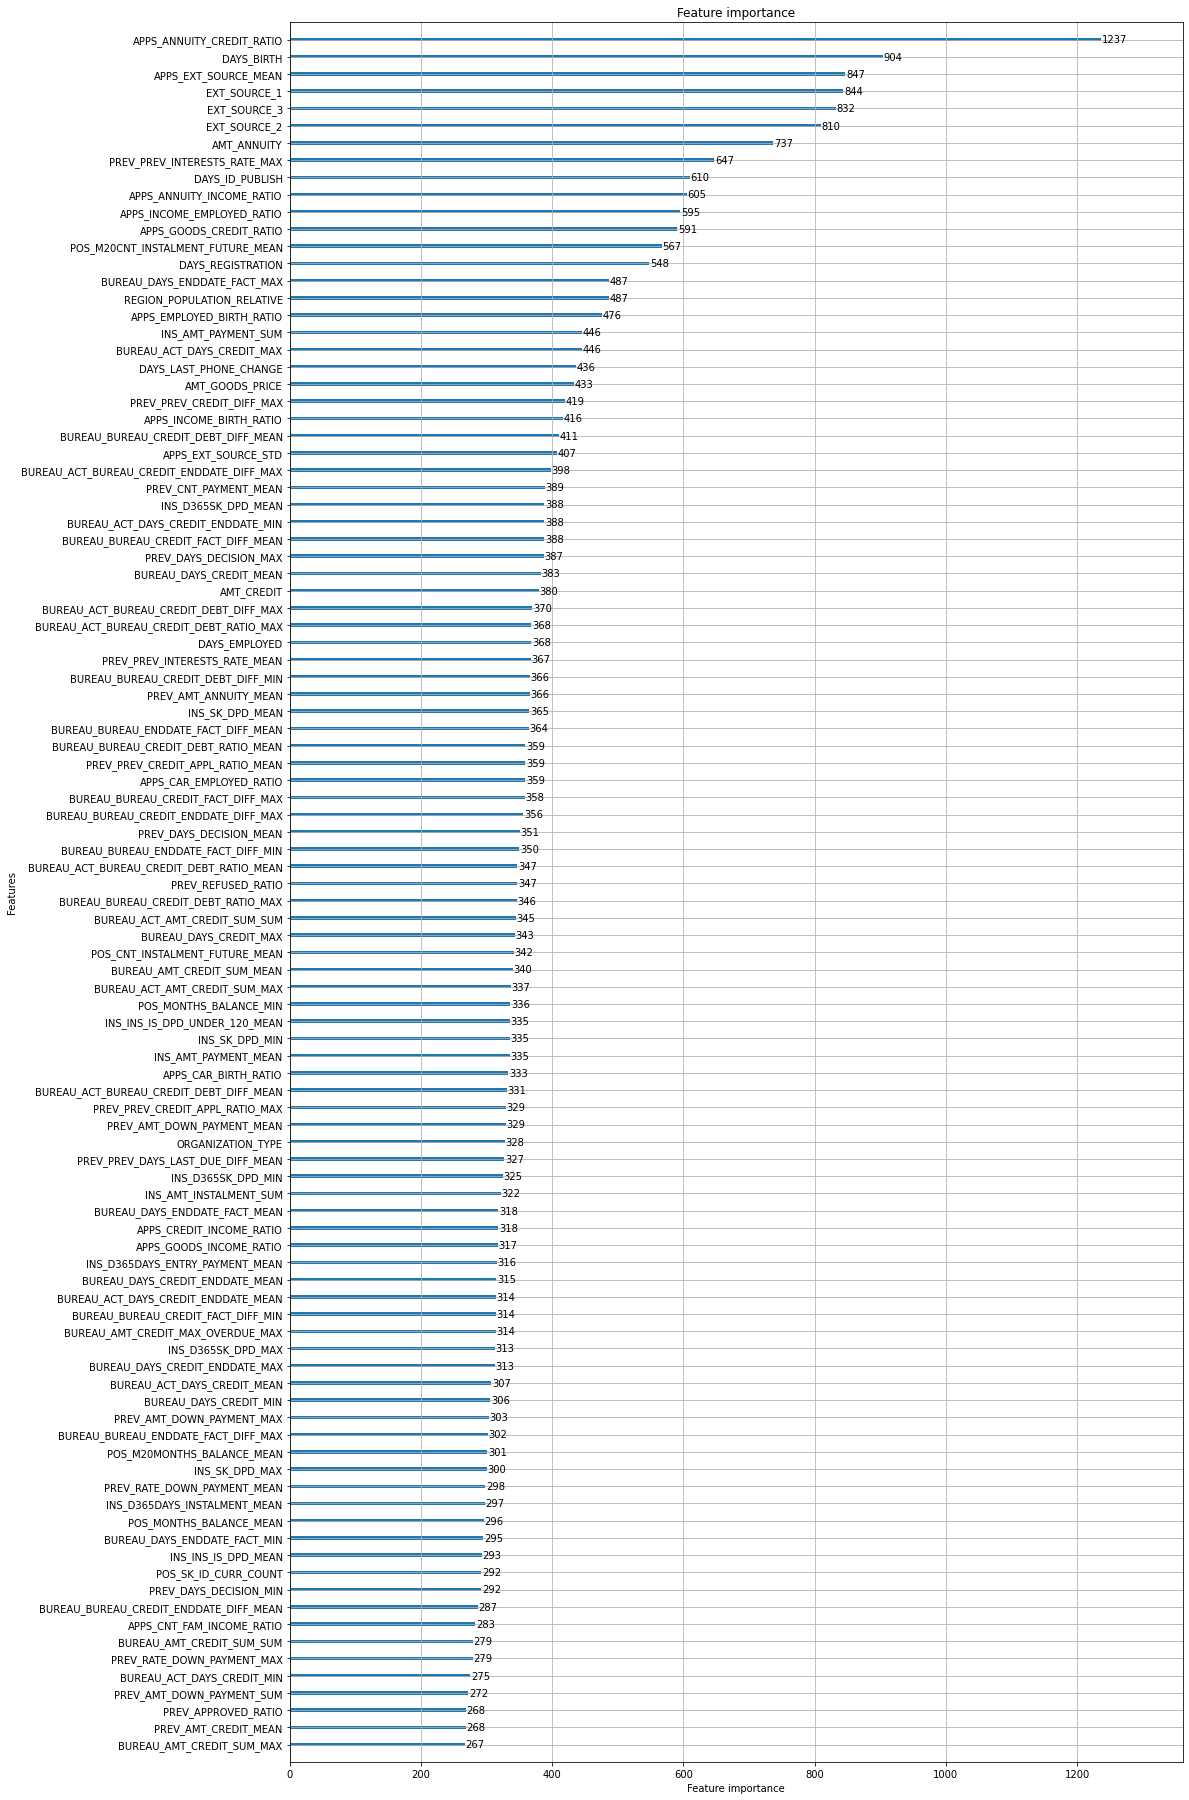

In [ ]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)